<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/tuned(97%2C90%2C71).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

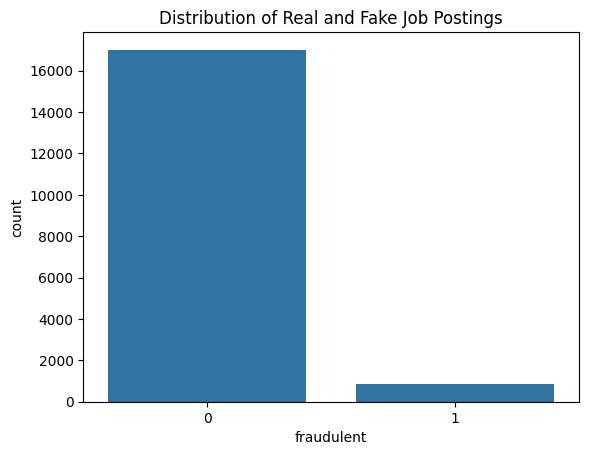

Accuracy of the Linear SVC model: 97.09%
Precision: 64.20%
Recall: 90.17%
F1-Score: 75.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3403
           1       0.64      0.90      0.75       173

    accuracy                           0.97      3576
   macro avg       0.82      0.94      0.87      3576
weighted avg       0.98      0.97      0.97      3576

Best Hyperparameters: {'C': 10}
Best Cross-Validation F1-Score: 0.9994127631315628


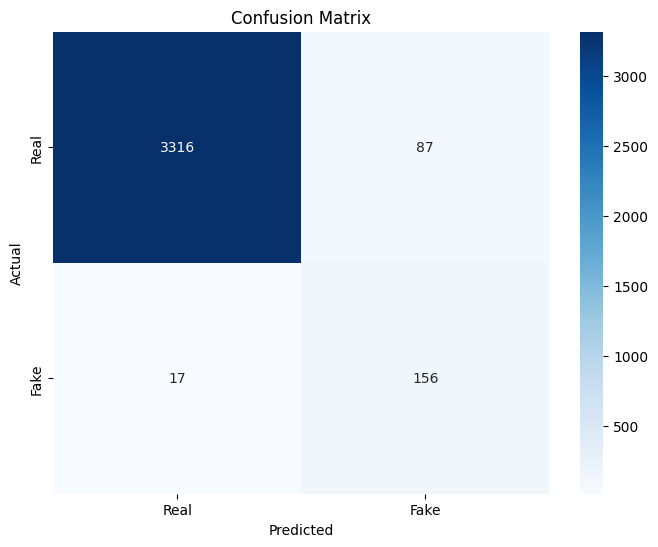

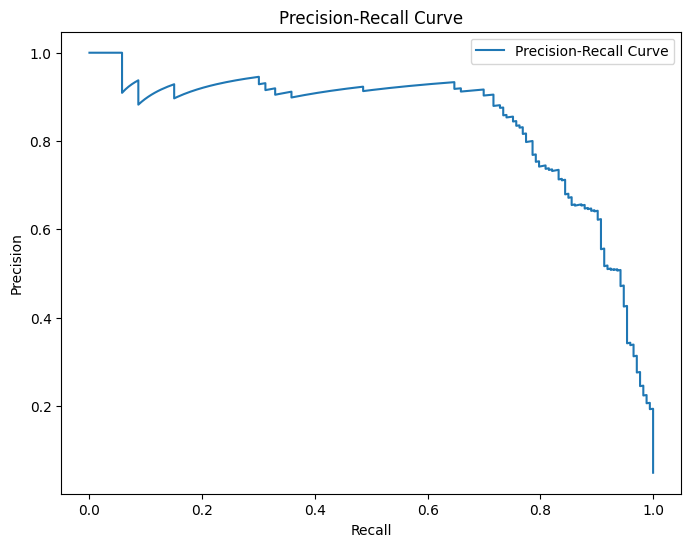


Precision with optimal threshold: 90.51%
Recall with optimal threshold: 71.68%
F1-Score with optimal threshold: 80.00%

Classification Report with optimal threshold:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.91      0.72      0.80       173

    accuracy                           0.98      3576
   macro avg       0.95      0.86      0.90      3576
weighted avg       0.98      0.98      0.98      3576



In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
df = pd.read_csv('fake_job_postings.csv')

# Step 2: Exploratory Data Analysis (EDA)
print(df.head())  # Display the first few rows of the dataset
print(df.info())  # Get information about the dataset
print(df['fraudulent'].value_counts())  # Check the distribution of the target variable

# Visualize the distribution of the target variable
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Real and Fake Job Postings')
plt.show()

# Step 3: Feature Engineering
# Combine text columns into a single feature
df['text'] = df['title'].fillna('') + ' ' + \
             df['location'].fillna('') + ' ' + \
             df['department'].fillna('') + ' ' + \
             df['company_profile'].fillna('') + ' ' + \
             df['description'].fillna('') + ' ' + \
             df['requirements'].fillna('') + ' ' + \
             df['benefits'].fillna('')

# Drop unnecessary columns
df = df[['text', 'fraudulent']]

# Step 4: Text Preprocessing
# Convert text to lowercase and remove special characters
df.loc[:, 'text'] = df['text'].str.lower()
df.loc[:, 'text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
df = df[df['text'] != ""]  # Remove empty rows

# Step 5: Feature Extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['text']).toarray()  # Convert text to TF-IDF features
y = df['fraudulent']  # Target variable

# Step 6: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 7: Oversampling using SMOTEENN to handle class imbalance
smote_enn = SMOTEENN(random_state=42, n_jobs=-1)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Step 8: Train the Linear SVC model with class weights
svc = LinearSVC(random_state=42, class_weight='balanced')  # Use class weights to handle imbalance
param_grid = {'C': [0.01, 0.1, 1, 10]}  # Hyperparameter grid for tuning
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1')  # Use F1-score for evaluation
grid_search.fit(X_train_res, y_train_res)
best_svc = grid_search.best_estimator_  # Get the best model

# Step 9: Evaluate the model
y_pred = best_svc.predict(X_test)  # Predict on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy of the Linear SVC model: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 10: Display results
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation F1-Score:", grid_search.best_score_)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 11: Precision-Recall Curve
y_scores = best_svc.decision_function(X_test)  # Get decision scores
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Step 12: Adjust the decision threshold to balance precision and recall
# Find the threshold that maximizes the F1-score
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)

# Print evaluation metrics with the optimal threshold
print(f"\nPrecision with optimal threshold: {precision_optimal * 100:.2f}%")
print(f"Recall with optimal threshold: {recall_optimal * 100:.2f}%")
print(f"F1-Score with optimal threshold: {f1_optimal * 100:.2f}%")

# Classification Report with the optimal threshold
print("\nClassification Report with optimal threshold:")
print(classification_report(y_test, y_pred_optimal))